In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [26]:
def show_images(images, titles, rows=1, cols=None):
    """Helper function to display multiple images with titles"""
    if cols is None:
        cols = len(images) // rows + (1 if len(images) % rows != 0 else 0)
    
    plt.figure(figsize=(15, 5 * rows))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i+1)
        if len(img.shape) == 3:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [27]:
def sift_interest_points(image_path):
    # Read image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Create SIFT detector
    sift = cv2.SIFT_create()
    
    # Detect keypoints
    keypoints = sift.detect(gray, None)
    
    # Draw keypoints
    img_with_keypoints = cv2.drawKeypoints(gray, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Display results
    show_images([img, img_with_keypoints], 
                ['Original Image', 'SIFT Interest Points'])
    
    return keypoints, img

In [28]:
def orb_feature_matching(img1_path, img2_path):
    # Read images
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    
    # Convert to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Initialize ORB detector
    orb = cv2.ORB_create()
    
    # Find keypoints and descriptors
    kp1, des1 = orb.detectAndCompute(gray1, None)
    kp2, des2 = orb.detectAndCompute(gray2, None)
    
    # Create BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # Match descriptors
    matches = bf.match(des1, des2)
    
    # Sort them by distance
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Draw matches
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:30], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Display results
    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title('ORB Feature Matching with BFMatcher')
    plt.axis('off')
    plt.show()
    
    return matches

In [29]:
def contour_detection_with_seeds(image_path):
    # Read image
    img = cv2.imread(image_path)
    original = img.copy()
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Apply threshold
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Noise removal with morphological operations
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # Distance transform
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    
    # Sure foreground area
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = sure_fg.astype(np.uint8)
    
    # Finding unknown region
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    
    # Add 1 to all labels so that background is not 0, but 1
    markers = markers + 1
    
    # Mark the unknown region with 0
    markers[unknown == 255] = 0
    
    # Apply watershed
    markers = cv2.watershed(img, markers)
    
    # Draw boundaries
    img[markers == -1] = [0, 0, 255]  # Mark boundaries in red
    
    # Find contours
    contours, _ = cv2.findContours((markers == -1).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw contours
    contour_img = original.copy()
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
    
    # Display results
    show_images([original, img, contour_img], 
                ['Original Image', 'Watershed Segmentation', 'Contour Detection'])
    
    return contours, img

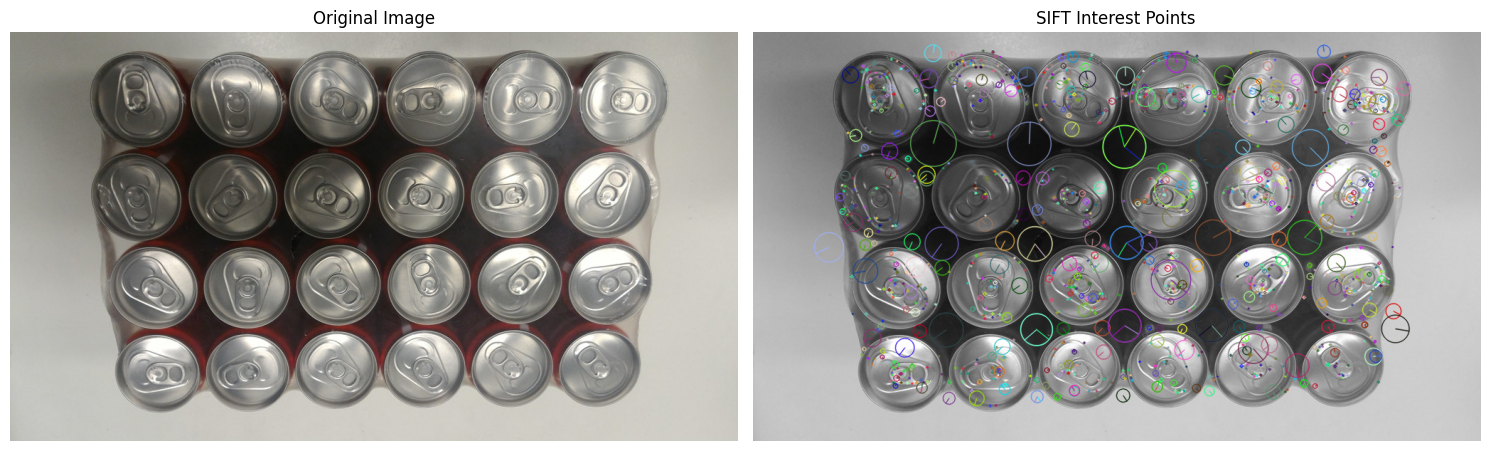

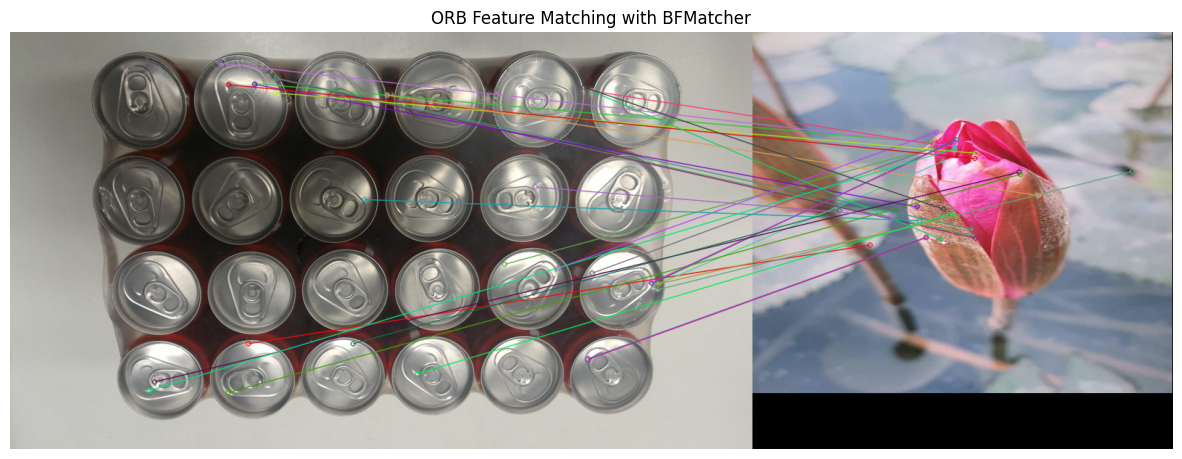

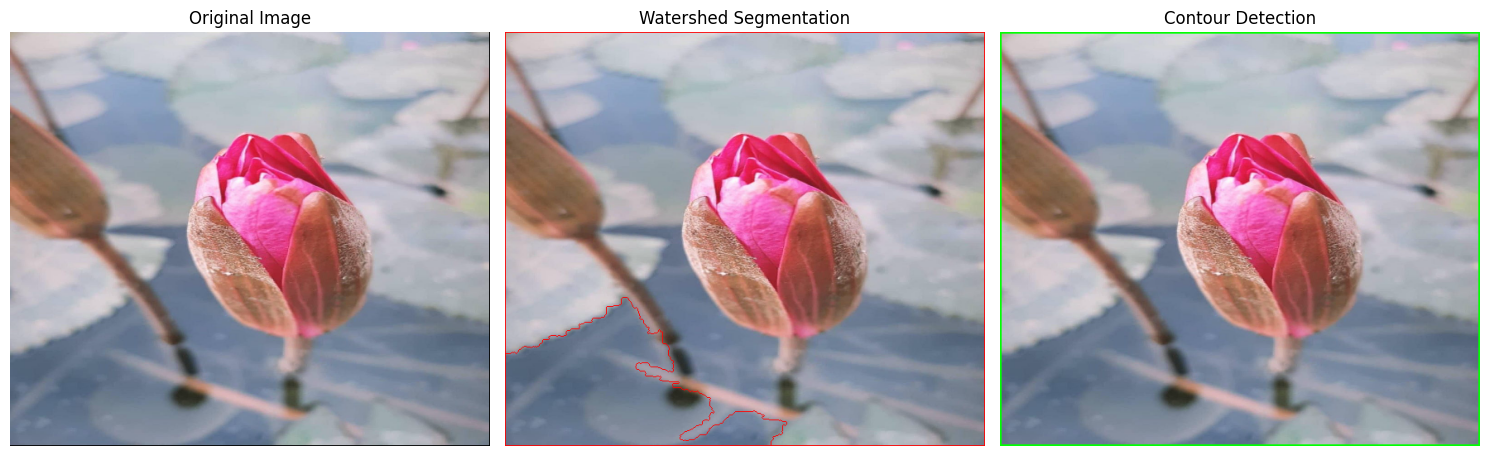

In [30]:
# For SIFT Interest Point Detection
image_path = 'image.jpg'
keypoints, img_with_keypoints = sift_interest_points(image_path)

# For ORB Feature Matching
img1_path = 'image.jpg'
img2_path = 'flower.png'
matches = orb_feature_matching(img1_path, img2_path)

# For Contour Detection with Custom Seeds
image_path = 'flower.png'
contours, segmented_img = contour_detection_with_seeds(image_path)

In [31]:
#Image restoration 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from skimage.metrics import peak_signal_noise_ratio as psnr
import random

In [32]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [46]:
def load_and_preprocess_data(dataset='mnist', grayscale=False):
    if dataset.lower() == 'mnist':
        # Load MNIST dataset
        (x_train, _), (x_test, _) = mnist.load_data()
        
        # Reshape and normalize
        x_train = x_train.astype('float32') / 255.
        x_test = x_test.astype('float32') / 255.
        
        # Reshape to include channel dimension
        x_train = x_train.reshape((-1, 28, 28, 1))
        x_test = x_test.reshape((-1, 28, 28, 1))
        
    elif dataset.lower() == 'cifar10':
        # Load CIFAR-10 dataset
        (x_train, _), (x_test, _) = cifar10.load_data()
        
        # Convert to grayscale if needed
        if grayscale:
            # Correct way to convert RGB to grayscale
            x_train_gray = np.dot(x_train.reshape(-1, 32, 32, 3), [0.299, 0.587, 0.114])
            x_test_gray = np.dot(x_test.reshape(-1, 32, 32, 3), [0.299, 0.587, 0.114])
            
            x_train = x_train_gray.reshape((-1, 32, 32, 1)).astype('float32') / 255.
            x_test = x_test_gray.reshape((-1, 32, 32, 1)).astype('float32') / 255.
        else:
            # Normalize RGB images
            x_train = x_train.astype('float32') / 255.
            x_test = x_test.astype('float32') / 255.
    
    print(f"Data loaded: Training set shape: {x_train.shape}, Test set shape: {x_test.shape}")
    return x_train, x_test

In [47]:
def add_noise(images, noise_type='gaussian', noise_factor=0.5):
    noisy_images = images.copy()
    
    if noise_type == 'gaussian':
        # Add Gaussian noise
        noise = np.random.normal(loc=0.0, scale=noise_factor, size=images.shape)
        noisy_images = images + noise
    
    elif noise_type == 'salt_pepper':
        # Salt and pepper noise
        s_vs_p = 0.5  # ratio of salt vs. pepper
        amount = noise_factor
        
        # Salt (white) noise - properly handle batch dimension
        for i in range(len(images)):
            # Get flat indices for this image
            num_salt = int(np.ceil(amount * images[i].size * s_vs_p))
            flat_indices = np.random.choice(images[i].size, num_salt, replace=False)
            
            # Convert to coordinates
            coords = np.unravel_index(flat_indices, images[i].shape)
            noisy_images[i][coords] = 1
            
            # Pepper (black) noise
            num_pepper = int(np.ceil(amount * images[i].size * (1 - s_vs_p)))
            flat_indices = np.random.choice(images[i].size, num_pepper, replace=False)
            coords = np.unravel_index(flat_indices, images[i].shape)
            noisy_images[i][coords] = 0
    
    # Clip values to [0, 1] range
    noisy_images = np.clip(noisy_images, 0., 1.)
    
    print(f"Noise added: Original shape: {images.shape}, Noisy shape: {noisy_images.shape}")
    return noisy_images

In [48]:
def apply_blur(images, kernel_size=3):
    """Apply a simple blur to the images"""
    # For efficiency with large datasets, we'll use TensorFlow's conv2d for blurring
    if len(images.shape) == 4:  # Batch of images
        # Create a blur kernel
        kernel = np.ones((kernel_size, kernel_size, images.shape[-1], images.shape[-1])) 
        kernel = kernel / (kernel_size * kernel_size)
        kernel = kernel.astype(np.float32)
        
        # Convert to tensor
        images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
        kernel_tensor = tf.convert_to_tensor(kernel, dtype=tf.float32)
        
        # Apply convolution (blur)
        blurred_tensor = tf.nn.conv2d(images_tensor, kernel_tensor, strides=[1, 1, 1, 1], padding='SAME')
        
        return blurred_tensor.numpy()
    else:
        raise ValueError("Expected 4D tensor with shape [batch, height, width, channels]")

In [49]:
def build_autoencoder(input_shape):
    """Build an autoencoder model with proper padding to maintain dimensions"""
    # Define input
    inputs = Input(shape=input_shape)
    
    # Extract dimensions for later verification
    h, w, c = input_shape
    
    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    # Calculate dimensions after encoding (important for determining decoder architecture)
    encoded_h = h // 8 if h % 8 == 0 else (h // 8) + 1
    encoded_w = w // 8 if w % 8 == 0 else (w // 8) + 1
    
    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Ensure the output has exactly the same shape as the input
    decoded = Conv2D(c, (3, 3), activation='sigmoid', padding='same')(x)
    
    # Explicitly reshape to match input dimensions if needed
    if decoded.shape[1:3] != (h, w):
        decoded = Reshape((h, w, c))(decoded)
    
    # Create and compile model
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return autoencoder

In [50]:
def train_autoencoder(model, x_train_degraded, x_train, x_test_degraded, x_test, batch_size=128, epochs=50):
    """Train the autoencoder model"""
    # Check shapes before training
    print(f"Training shapes - Input: {x_train_degraded.shape}, Target: {x_train.shape}")
    print(f"Validation shapes - Input: {x_test_degraded.shape}, Target: {x_test.shape}")
    
    # Callbacks
    checkpoint = ModelCheckpoint('best_autoencoder.h5', monitor='val_loss', save_best_only=True, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        x_train_degraded, x_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test_degraded, x_test),
        callbacks=[checkpoint, early_stopping],
        verbose=1
    )
    
    return model, history

In [51]:
def evaluate_restoration(model, x_original, x_degraded, num_samples=5):
    """Evaluate the restored images and compute PSNR"""
    # Predict restored images
    print("Restoring images...")
    x_restored = model.predict(x_degraded)
    
    # Calculate PSNR
    psnr_degraded = []
    psnr_restored = []
    
    print("Calculating PSNR...")
    for i in range(len(x_original)):
        orig = x_original[i].squeeze()
        deg = x_degraded[i].squeeze()
        rest = x_restored[i].squeeze()
        
        # Calculate PSNR (handle different dimensions)
        if len(orig.shape) == 3:  # RGB
            psnr_d = psnr(orig, deg, data_range=1.0)
            psnr_r = psnr(orig, rest, data_range=1.0)
        else:  # Grayscale
            psnr_d = psnr(orig, deg, data_range=1.0)
            psnr_r = psnr(orig, rest, data_range=1.0)
        
        psnr_degraded.append(psnr_d)
        psnr_restored.append(psnr_r)
    
    print(f"Average PSNR (degraded): {np.mean(psnr_degraded):.4f}")
    print(f"Average PSNR (restored): {np.mean(psnr_restored):.4f}")
    print(f"PSNR improvement: {np.mean(psnr_restored) - np.mean(psnr_degraded):.4f}")
    
    # Display random samples
    indices = np.random.choice(len(x_original), num_samples, replace=False)
    
    plt.figure(figsize=(15, 5 * num_samples))
    for i, idx in enumerate(indices):
        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        if x_original.shape[-1] == 1:
            plt.imshow(x_original[idx].reshape(x_original.shape[1], x_original.shape[2]), cmap='gray')
        else:
            plt.imshow(x_original[idx])
        plt.title(f"Original (Sample {idx})")
        plt.axis('off')
        
        # Degraded image
        plt.subplot(num_samples, 3, i*3 + 2)
        if x_degraded.shape[-1] == 1:
            plt.imshow(x_degraded[idx].reshape(x_degraded.shape[1], x_degraded.shape[2]), cmap='gray')
        else:
            plt.imshow(x_degraded[idx])
        plt.title(f"Degraded (PSNR: {psnr_degraded[idx]:.2f})")
        plt.axis('off')
        
        # Restored image
        plt.subplot(num_samples, 3, i*3 + 3)
        if x_restored.shape[-1] == 1:
            plt.imshow(x_restored[idx].reshape(x_restored.shape[1], x_restored.shape[2]), cmap='gray')
        else:
            plt.imshow(x_restored[idx])
        plt.title(f"Restored (PSNR: {psnr_restored[idx]:.2f})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return np.mean(psnr_restored)

In [52]:
def main(dataset='mnist', noise_type='gaussian', noise_factor=0.3, batch_size=128, epochs=50):
    """Main function to run the image restoration pipeline"""
    # Step 1: Load and preprocess data
    grayscale = True if dataset.lower() == 'cifar10' else False
    x_train, x_test = load_and_preprocess_data(dataset, grayscale)
    
    # Step 2: Create degraded images (noisy or blurred)
    print(f"Adding {noise_type} noise with factor {noise_factor}...")
    x_train_degraded = add_noise(x_train, noise_type=noise_type, noise_factor=noise_factor)
    x_test_degraded = add_noise(x_test, noise_type=noise_type, noise_factor=noise_factor)
    
    # Step 3: Build the autoencoder model
    print("Building autoencoder model...")
    input_shape = x_train.shape[1:]
    model = build_autoencoder(input_shape)
    model.summary()
    
    # Step 4: Train the model
    print("Training autoencoder...")
    model, history = train_autoencoder(model, 
                                      x_train_degraded, 
                                      x_train, 
                                      x_test_degraded, 
                                      x_test, 
                                      batch_size=batch_size, 
                                      epochs=epochs)
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Autoencoder Training Progress')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Step 5: Evaluate the model
    print("Evaluating restoration performance...")
    psnr_score = evaluate_restoration(model, x_test, x_test_degraded)
    
    return model, history, psnr_score

In [53]:
if __name__ == "__main__":
    # Run with default parameters (MNIST, gaussian noise)
    model, history, psnr_score = main(dataset='mnist', 
                                   noise_type='gaussian', 
                                   noise_factor=0.3, 
                                   batch_size=128, 
                                   epochs=20)  # Reduced epochs for quicker execution
    
    print(f"Final PSNR score: {psnr_score:.4f}")

Data loaded: Training set shape: (60000, 28, 28, 1), Test set shape: (10000, 28, 28, 1)
Adding gaussian noise with factor 0.3...
Noise added: Original shape: (60000, 28, 28, 1), Noisy shape: (60000, 28, 28, 1)
Noise added: Original shape: (10000, 28, 28, 1), Noisy shape: (10000, 28, 28, 1)
Building autoencoder model...


ValueError: The total size of the tensor must be unchanged. Received: input_shape=(32, 32, 1), target_shape=(28, 28, 1)

In [41]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time
from datetime import datetime

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

In [43]:
IMAGE_SIZE = (224, 224)  # Standard input size for MobileNet
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
DATA_DIR = "dog_dataset"

In [44]:
def create_mobilenet_model(version, num_classes):
    """
    Create a MobileNet model of specified version for transfer learning.
    
    Args:
        version: String, one of 'v1', 'v2', or 'v3'
        num_classes: Integer, number of output classes
    
    Returns:
        A compiled Keras model
    """
    if version == 'v1':
        base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
        model_name = "MobileNetV1"
    elif version == 'v2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
        model_name = "MobileNetV2"
    elif version == 'v3':
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
        model_name = "MobileNetV3"
    else:
        raise ValueError("Version must be one of 'v1', 'v2', or 'v3'")
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, model_name


In [45]:
def prepare_data_generators(data_dir, image_size, batch_size):
    """
    Prepare train, validation, and test data generators.
    
    Args:
        data_dir: String, path to dataset directory
        image_size: Tuple, target image dimensions
        batch_size: Integer, batch size
    
    Returns:
        train_generator, valid_generator, test_generator, num_classes, class_names
    """
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )
    
    # Only rescaling for validation and test data
    valid_test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )
    
    # Training generator
    train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )
    
    # Validation generator
    valid_generator = valid_test_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )
    
    # Test generator, if test folder exists
    test_dir = os.path.join(data_dir, 'test')
    if os.path.exists(test_dir):
        test_datagen = ImageDataGenerator(rescale=1./255)
        test_generator = test_datagen.flow_from_directory(
            test_dir,
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False
        )
    else:
        # If no test folder, use validation data as test
        test_generator = valid_generator
    
    num_classes = len(train_generator.class_indices)
    class_names = list(train_generator.class_indices.keys())
    
    return train_generator, valid_generator, test_generator, num_classes, class_names


In [46]:
def train_and_evaluate_model(model, model_name, train_generator, valid_generator, test_generator, epochs):
    """
    Train and evaluate a given model.
    
    Args:
        model: A compiled Keras model
        model_name: String, name of the model
        train_generator: Training data generator
        valid_generator: Validation data generator
        test_generator: Test data generator
        epochs: Integer, number of training epochs
    
    Returns:
        history: Training history
        evaluation: Model evaluation results
        inference_time: Time taken for inference on test set
    """
    print(f"\nTraining {model_name}...")
    
    # Create a directory for saving models
    os.makedirs('models', exist_ok=True)
    
    # Callbacks
    checkpoint = ModelCheckpoint(
        f'models/{model_name}_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    
    # Train the model
    start_time = time.time()
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=valid_generator,
        validation_steps=valid_generator.samples // valid_generator.batch_size,
        epochs=epochs,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        verbose=1
    )
    training_time = time.time() - start_time
    
    # Evaluate the model
    print(f"\nEvaluating {model_name}...")
    evaluation = model.evaluate(test_generator)
    
    # Measure inference time
    start_time = time.time()
    model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
    inference_time = time.time() - start_time
    
    return history, evaluation, training_time, inference_time


In [47]:
def get_predictions(model, test_generator):
    """
    Get predictions for the test data.
    
    Args:
        model: Trained Keras model
        test_generator: Test data generator
    
    Returns:
        true_labels: Ground truth labels
        pred_labels: Predicted labels
        pred_probs: Prediction probabilities
    """
    # Reset the generator
    test_generator.reset()
    
    # Get predictions
    pred_probs = model.predict(
        test_generator,
        steps=test_generator.samples // test_generator.batch_size + 1,
        verbose=1
    )
    
    # Get true labels and predicted labels
    true_labels = test_generator.classes
    pred_labels = np.argmax(pred_probs, axis=1)
    
    # Adjust pred_labels length to match true_labels
    if len(pred_labels) > len(true_labels):
        pred_labels = pred_labels[:len(true_labels)]
        pred_probs = pred_probs[:len(true_labels)]
    
    return true_labels, pred_labels, pred_probs

In [48]:
def plot_training_history(histories, model_names):
    """
    Plot training and validation accuracy/loss curves for multiple models.
    
    Args:
        histories: List of training histories
        model_names: List of model names
    """
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))
    
    # Training & validation accuracy
    for history, name in zip(histories, model_names):
        axs[0, 0].plot(history.history['accuracy'], label=f'{name} Train')
        axs[0, 1].plot(history.history['val_accuracy'], label=f'{name} Validation')
    
    axs[0, 0].set_title('Training Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend()
    axs[0, 0].grid(True)
    
    axs[0, 1].set_title('Validation Accuracy')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend()
    axs[0, 1].grid(True)
    
    # Training & validation loss
    for history, name in zip(histories, model_names):
        axs[1, 0].plot(history.history['loss'], label=f'{name} Train')
        axs[1, 1].plot(history.history['val_loss'], label=f'{name} Validation')
    
    axs[1, 0].set_title('Training Loss')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].legend()
    axs[1, 0].grid(True)
    
    axs[1, 1].set_title('Validation Loss')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].legend()
    axs[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('mobilenet_comparison_training_history.png')
    plt.show()

In [49]:
def plot_confusion_matrices(true_labels_list, pred_labels_list, model_names, class_names):
    """
    Plot confusion matrices for multiple models.
    
    Args:
        true_labels_list: List of arrays of true labels
        pred_labels_list: List of arrays of predicted labels
        model_names: List of model names
        class_names: List of class names
    """
    n_models = len(model_names)
    fig, axs = plt.subplots(1, n_models, figsize=(6*n_models, 5))
    
    if n_models == 1:
        axs = [axs]
    
    for i, (true_labels, pred_labels, name) in enumerate(zip(true_labels_list, pred_labels_list, model_names)):
        cm = confusion_matrix(true_labels, pred_labels)
        
        # Normalize confusion matrix
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Create heatmap
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=axs[i], 
                    xticklabels=class_names, yticklabels=class_names)
        axs[i].set_title(f'{name} Confusion Matrix')
        axs[i].set_ylabel('True Label')
        axs[i].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.savefig('mobilenet_comparison_confusion_matrices.png')
    plt.show()

In [50]:
def create_performance_comparison(evaluations, training_times, inference_times, model_names):
    """
    Create a performance comparison table.
    
    Args:
        evaluations: List of evaluation results
        training_times: List of training times
        inference_times: List of inference times
        model_names: List of model names
    
    Returns:
        DataFrame: Performance comparison table
    """
    comparison_data = {
        'Model': model_names,
        'Test Loss': [eval[0] for eval in evaluations],
        'Test Accuracy': [eval[1] for eval in evaluations],
        'Training Time (s)': training_times,
        'Inference Time (s)': inference_times
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Add model sizes
    model_sizes = []
    for name in model_names:
        if name == "MobileNetV1":
            model_sizes.append("4.2 MB")
        elif name == "MobileNetV2":
            model_sizes.append("14 MB")
        else:  # MobileNetV3
            model_sizes.append("21 MB")
    
    comparison_df['Model Size'] = model_sizes
    
    # Format accuracy as percentage
    comparison_df['Test Accuracy'] = comparison_df['Test Accuracy'].apply(lambda x: f"{x*100:.2f}%")
    
    return comparison_df

In [54]:
def main():
    """Main execution function."""
    print("Starting MobileNet Dog Breed Classification Comparison")
    print(f"Using TensorFlow version: {tf.__version__}")
    print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
    
    # Prepare data generators
    print("\nPreparing data generators...")
    train_generator, valid_generator, test_generator, num_classes, class_names = prepare_data_generators(
        DATA_DIR, IMAGE_SIZE, BATCH_SIZE
    )
    
    print(f"Number of classes: {num_classes}")
    print(f"Number of training samples: {train_generator.samples}")
    print(f"Number of validation samples: {valid_generator.samples}")
    print(f"Number of test samples: {test_generator.samples}")
    
    # Lists to store results
    models = []
    model_names = []
    histories = []
    evaluations = []
    training_times = []
    inference_times = []
    true_labels_list = []
    pred_labels_list = []
    
    # Train and evaluate each MobileNet version
    for version in ['v1', 'v2', 'v3']:
        # Create and compile model
        model, model_name = create_mobilenet_model(version, num_classes)
        models.append(model)
        model_names.append(model_name)
        
        # Train and evaluate model
        history, evaluation, training_time, inference_time = train_and_evaluate_model(
            model, model_name, train_generator, valid_generator, test_generator, EPOCHS
        )
        
        # Store results
        histories.append(history)
        evaluations.append(evaluation)
        training_times.append(training_time)
        inference_times.append(inference_time)
        
        # Get predictions
        true_labels, pred_labels, _ = get_predictions(model, test_generator)
        true_labels_list.append(true_labels)
        pred_labels_list.append(pred_labels)
        
        # Print evaluation results
        print(f"\n{model_name} Evaluation Results:")
        print(f"Test Loss: {evaluation[0]:.4f}")
        print(f"Test Accuracy: {evaluation[1]:.4f}")
        print(f"Training Time: {training_time:.2f} seconds")
        print(f"Inference Time: {inference_time:.2f} seconds")
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(true_labels, pred_labels, target_names=class_names))
    
    # Visualize training history
    plot_training_history(histories, model_names)
    
    # Plot confusion matrices
    plot_confusion_matrices(true_labels_list, pred_labels_list, model_names, class_names)
    
    # Create performance comparison table
    comparison_df = create_performance_comparison(evaluations, training_times, inference_times, model_names)
    print("\nPerformance Comparison:")
    print(comparison_df)
    
    # Save comparison to CSV
    comparison_df.to_csv('mobilenet_comparison_results.csv', index=False)
    print("\nResults saved to mobilenet_comparison_results.csv")

if __name__ == "__main__":
    main()

Starting MobileNet Dog Breed Classification Comparison
Using TensorFlow version: 2.18.0
GPU Available: []

Preparing data generators...
Found 16464 images belonging to 1 classes.
Found 4116 images belonging to 1 classes.
Number of classes: 1
Number of training samples: 16464
Number of validation samples: 4116
Number of test samples: 4116

Training MobileNetV1...
Epoch 1/20


/opt/homebrew/lib/python3.11/site-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


514/514 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to models/MobileNetV1_best.h5


514/514 ━━━━━━━━━━━━━━━━━━━━ 163s 314ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
  1/514 ━━━━━━━━━━━━━━━━━━━━ 2:15 265ms/step - accuracy: 1.0000 - loss: 0.0000e+00

/opt/homebrew/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


KeyboardInterrupt: 